# 1.3.3: World Population (Iteration, Part Two)

<br>

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---


In the previous notebook we developed a population model where net growth during each time step is proportional to the current population. This model seems more realistic as an explanation of population growth than the constant growth model, but it does not fit the data as well.

<br>

There are a few things we could try to improve the model:

-   Maybe net growth depends on the current population, but the
    relationship is quadratic, not linear.

-   Maybe the net growth rate varies over time.

In this chapter, we'll explore the first option.
In the exercises, you will have a chance to try the second. 

<br>

---

In addition to importing the usual libraries, we'll go ahead and download the population data, using the same process as in previous chapters:

In [ ]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


In [ ]:
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/World_population_estimates.html'
# If you are using this notebook offline, you will need to upload this data
# from the Images_and_Data folder on your local computer.  
# Comment out the line above, and uncomment the
# line below this one, and run this cell
# filename = '../Images_and_Data/Data/World_population_estimates.html'

tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']
un = table2.un / 1e9
census = table2.census / 1e9

def plot_estimates():
    census.plot(style=':', label='US Census',legend=True)
    un.plot(style='--', label='UN DESA', xlabel='Year', 
             ylabel='World population (billion)',
           legend=True)

---

## Quadratic Growth Model

The proportional model that we explored in the previous notebook calculates population growth as a function of the growth coefficient $\alpha$ and the current population $p$: 

$$\Delta p = \alpha p$$

where $\Delta p$ is the net annual growth in the population.

<br>


In hopes of more closely matching the population data, in this notebook we'll test out a more complex *quadratic model* that adds another term to the right hand side:

$$\Delta p = \alpha p + \beta p^2$$

where $\beta$ is a second growth coefficient.




### Implementing the model

Remember that we rewrote `run_simulation` so that it takes the change function as one of its parameters?

In [ ]:
def run_simulation(system, change_func):
    results = pd.Series([],dtype=object)
    results[system['t_0']] = system['p_0']
    
    for t in range(system['t_0'], system['t_end']):
        growth = change_func(t, results[t], system)
        results[t+1] = results[t] + growth
        
    return results

That comes in handy here!  All we need to do to test out our new model is to write a new change function:

In [ ]:
def change_func_quad(t, pop, system):
    return system['alpha'] * pop + system['beta'] * pop**2

Here's the `System` object we'll use, initialized with `t_0`, `p_0`, and `t_end`.

In [ ]:
t_0 = census.index[0]
p_0 = census[t_0]
t_end = census.index[-1]

system = dict(t_0=t_0,
                p_0=p_0,
                t_end=t_end)

Now we have to add the parameters `alpha` and `beta` .
These values were chosen by trial and error; we'll see better ways to do it later.

In [ ]:
system['alpha'] = 25 / 1000
system['beta'] = -1.8 / 1000

And here's how we run it:

In [ ]:
results = run_simulation(system, change_func_quad)



Here are the results.

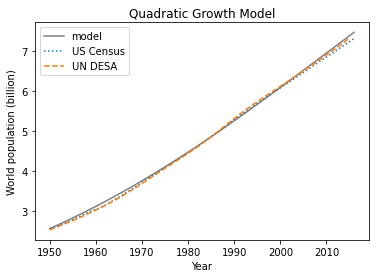

In [ ]:
results.plot(color='gray', label='model',title='Quadratic Growth Model',
             legend=True)
plot_estimates()

The model fits the data well over the whole range, with just a bit of space between them in the 1960s.

<br>

It is not entirely surprising that the quadratic model fits better than the
constant and proportional models, because it has two parameters we can
choose where the other models have only one. In general, the more
parameters you have to play with, the better you should expect the model
to fit.

<br>

Be careful, though.  While choosing a really complex function for a curve fit might give you an accurate fit, its explanatory usefulness can suffer: what do all of those coefficients represent in the physical system?  What do `alpha` and `beta` *mean*?

<br>

But in this case, the quadratic model
might be a good choice for physical reasons, too: that is, there is a
legitimate reason to expect the relationship between growth and
population to have this form.  To understand why, let's look at net growth as a function of population.

<br>

✅  Active Reading: Why might a model with a lot of coefficients be undesirable, even if it was very accurate? (Answer in a text box)

### Investigating net growth in a quadratic system

Let's plot the relationship between growth and population in the quadratic model.  To do this, we'll make an array of 101 populations from 0 to 15 billion.  In the past, when we wanted an object that contained a string numbers, we used `range`.  But `range` only works with integers.  To get a sequence of non-integer values, we can use `linspace`, which is defined NumPy:

In [ ]:
from numpy import linspace

pop_array = linspace(0, 15, 101)

The arguments indicate where the sequence should start and stop, and how many elements it should contain. In this example, the sequence contains 101 equally-spaced numbers, starting at 0 and ending at 15.  The result is a NumPy array, which is a new kind of object we have not seen before. An array is a object that contains a sequence of numbers:


In [ ]:
pop_array

array([ 0.  ,  0.15,  0.3 ,  0.45,  0.6 ,  0.75,  0.9 ,  1.05,  1.2 ,
        1.35,  1.5 ,  1.65,  1.8 ,  1.95,  2.1 ,  2.25,  2.4 ,  2.55,
        2.7 ,  2.85,  3.  ,  3.15,  3.3 ,  3.45,  3.6 ,  3.75,  3.9 ,
        4.05,  4.2 ,  4.35,  4.5 ,  4.65,  4.8 ,  4.95,  5.1 ,  5.25,
        5.4 ,  5.55,  5.7 ,  5.85,  6.  ,  6.15,  6.3 ,  6.45,  6.6 ,
        6.75,  6.9 ,  7.05,  7.2 ,  7.35,  7.5 ,  7.65,  7.8 ,  7.95,
        8.1 ,  8.25,  8.4 ,  8.55,  8.7 ,  8.85,  9.  ,  9.15,  9.3 ,
        9.45,  9.6 ,  9.75,  9.9 , 10.05, 10.2 , 10.35, 10.5 , 10.65,
       10.8 , 10.95, 11.1 , 11.25, 11.4 , 11.55, 11.7 , 11.85, 12.  ,
       12.15, 12.3 , 12.45, 12.6 , 12.75, 12.9 , 13.05, 13.2 , 13.35,
       13.5 , 13.65, 13.8 , 13.95, 14.1 , 14.25, 14.4 , 14.55, 14.7 ,
       14.85, 15.  ])

Now I'll use the quadratic model to compute net growth for each population, and create a `Series` that holds the relationship between population and net growth for the quadratic model.  

<br>

We can add and multiply arrays by integers in the same way we multiplied `Series` (note: to add arrays, they must have the same number of elements):

In [ ]:
change_array = (system['alpha'] * pop_array + 
                system['beta'] * pop_array**2)

quad_net_growth = pd.Series(data=change_array,index=pop_array)

And let's plot the relationship:

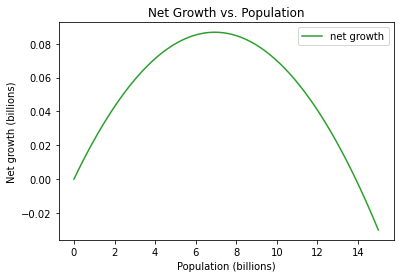

In [ ]:
quad_net_growth.plot(label='net growth', color='C2',
                     xlabel='Population (billions)',
                     ylabel='Net growth (billions)',
                     title='Net Growth vs. Population',
                    legend=True);

Look at this plot, remembering that the x-axis is not time, as in the previous figures, but population.  

We can divide this curve into four kinds of behavior:

-   When the population is less than 3 billion, net growth is
    proportional to population, as in the proportional model (i.e. it is linear). In this
    range, the population grows slowly because the population is small.

-   Between 3 billion and 10 billion, the population grows quickly
    because there are a lot of people.

-   Above 10 billion, population grows more slowly, eventually reaching an equilibrium point at about 14 billion where net growth is 0 (i.e. the population does not change).

-   Above 14 billion, the death rate
    exceeds the birth rate and net growth becomes negative.





✅  Active Reading: Why might a quadratic modelfor population growth, in which population growth slows down and even reverses as the population reaches a certain point, make sense?  Why would growth rates get *lower* as the population grew larger?

In a text box below, suggest a couple reasons why this might be the case.

### Finding Equilibrium

Looking at the plot above tells us several interesting things.  First, with these parameters, the peak growth rate happens when the population is between 7-8 billion.  Second, we can see a point where growth is 0.  The *equilibrium point* is the population, $p$, where net population growth, $\Delta p$, is 0.

<br>

We can compute it by finding the roots, or zeros, of this equation: 

$$\Delta p = \alpha p + \beta p^2$$ 

where $\alpha$ and $\beta$ are the parameters of the model. 
If rewrite the right hand side like this: 

$$\Delta p = p (\alpha + \beta p)$$ 

we can see that net growth $\Delta p$ is zero when either of the factors on the right hand side are zero:

 $$p=0$$
 
 $$\alpha + \beta p = 0$$

If either of these conditions is true, the population growth is zero.  The first equation tells us that this is true when the population is zero: this solution is called a "trivial" solution, because it is an obvious and not useful solution (of course there is no growth if there are no people).  The second equation, though, leads to a useful solution:

$$ p = -\alpha / \beta$$

This gives us an analytical solution to equilibrium population in our model:

In [ ]:
-system['alpha']/ system['beta']

13.88888888888889

With these parameters, net growth is 0 when the population is about 13.9 billion.



In the context of population modeling, the quadratic model is more
conventionally written like this: 

$$\Delta p = r p (1 - p / K)$$ 

This is the same model; it's just a different way to *parameterize* it. By comparing this equation $\Delta p = \alpha p + \beta p^2$ and doing a little algebra, we can decipher that $r=\alpha$ and $K=-\alpha/\beta$.

<br>

Why use this more complex form of the equation?  More explanatory reasons! That is, it is easier to interpret the parameters: 

* $r$ is the unconstrained growth rate, observed when $p$ is small
* $K$ is the equilibrium point

$K$ is also called the *carrying capacity*, since it indicates the maximum population the environment can sustain.

<br>  

---

## Summary and Exercises

In this notebook we implemented a quadratic growth model where net growth depends on the current population and the population squared.
This model fits the data well, *and* the model gives us a useful way to think about population growth.  This is much improved over the linear and proportional models!

<br>

---

### Exercise 1

 In a previous section, we saw a different way to parameterize the quadratic model:

$$ \Delta p = r p (1 - p / K) $$

where $r=\alpha$ and $K=-\alpha/\beta$.  

Write a version of `change_func` that implements this version of the model.  Test it by computing the values of `r` and `K` that correspond to `alpha=0.025` and `beta=-0.0018`, and confirm that you get the same results for the annual growth in the first year of our model.

In [ ]:
# Write new change_func with r and K and a system that includes values for r and K
system = dict(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

system['r'] = system['alpha']
system['K'] = -system['alpha']/system['beta']

def change_func_quad_rk(t, pop, system):
    return (system['r'] * pop)*(1 - pop/system['K'])

In [ ]:
# Compare the growth created in 1950-1951 using the new and old form of change_func_quad
test1 = change_func_quad_rk(t_0,p_0,system)

test2 = change_func_quad(t_0,p_0,system)

print(test1,test2)

0.052166080552828675 0.052166080552828675


### Exercise 2

  What happens if we start with an initial population above the carrying capacity, like 20 billion?   Run the model from 1950 to 2016, but start with initial populations between 1 and 20 billion, and plot the results for each simulation on the same graph.

A couple hints: 

1) If there are too many labels in the legend, you can plot results like this:

```
    results.plot(label='_nolegend')
```

2) Everytime you use the plot function with a Series (i.e. `results.plot()`), it saves that sequence of data for a plot.  When you use the function a second time with a different sequence (say, with a plot with a different initial population), it does not erase the first sequence, but adds onto it.  So to put multiple lines on the same plot, you just need to run `results.plot` multiple times with a different `results` series.

3) In the final line of the cell, include `plot_estimates()` so that you can see how the census data compares to these models.


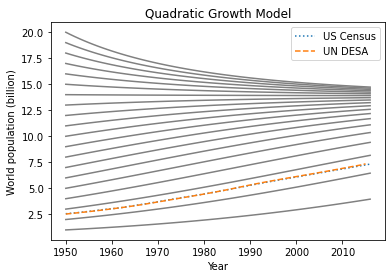

In [ ]:
# Solution goes here
starting_pop = linspace(1,20,20)
for pop_0 in starting_pop:
    system['p_0'] = pop_0
    results = run_simulation(system,change_func_quad_rk)
    results.plot(color='gray', label='_nolegend', 
                 title='Quadratic Growth Model')
    
plot_estimates()


### Exercise 3

What does this plot tell you about quadratically modeled population growth?  Will the lines every cross?  What starting point would lead to the largest stable population?  Does this plot suggest any ways that a quadratic model might be problematic?

<br>

Write a short paragraph exploring these questions.